In [2]:
import torch
import torch.nn.functional as F
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms

In [5]:
# Load ImageNet labels (label names)
with open('imagenet_classes.txt') as f:
    label_names = [line.strip() for line in f.readlines()]
# Mean and Std from ImageNet
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])
# No resizing and center crop necessary as images are already preprocessed.
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN,
                         std=NORM_STD)
])

img = Image.open('cat.jpg')  # Replace with your image path
img_tensor = plain_transforms(img).unsqueeze(0)  # Add batch dimension
# Step 2: Load the ResNet34 model
model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
model.eval()  # Set the model to evaluation mode

# Step 3: Initialize the adversarial patch
patch_size = (1, 3, 50, 50)  # The size of the patch
patch = torch.rand(patch_size, requires_grad=True)  # Random initialization of the patch

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\Administrator/.cache\torch\hub\checkpoints\resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [6]:
def resize_patch(patch, img_tensor):
    # Get image dimensions (height, width)
    img_height, img_width = img_tensor.size(2), img_tensor.size(3)
    # Resize the patch to match the image dimensions
    patch_resized = F.interpolate(patch, size=(img_height, img_width), mode='bilinear', align_corners=False)
    return patch_resized

# Updated apply_patch function
def apply_patch(image, patch, position=(0, 0)):
    # Resizing the patch to match the image dimensions
    patch_resized = resize_patch(patch, image)

    # Ensure that the patch can be applied at the given position
    img_height, img_width = image.size(2), image.size(3)
    patch_height, patch_width = patch_resized.size(2), patch_resized.size(3)

    # Ensure that the patch can fit into the image at the specified position
    if position[0] + patch_height <= img_height and position[1] + patch_width <= img_width:
        patched_image = image.clone()
        patched_image[:, :, position[0]:position[0] + patch_height, position[1]:position[1] + patch_width] = patch_resized
        return patched_image
    else:
        raise ValueError("Patch exceeds image dimensions at the specified position.")

In [7]:
# PGD loop to generate adversarial patch
optimizer = torch.optim.Adam([patch], lr=0.01)
label = 248
print(label_names[label])
target_class = torch.tensor([label], dtype=torch.long)

num_iterations = 100  # Number of iterations for the attack

for i in range(num_iterations):
    optimizer.zero_grad()  # Zero out gradients
    patched_img_tensor = apply_patch(img_tensor, patch)  # Apply the patch after resizing
    logits = model(patched_img_tensor)  # Get the logits (model output)
    loss = F.cross_entropy(logits, target_class)  # Compute the loss
    loss.backward()  # Backpropagate the gradients
    optimizer.step()  # Update the patch

    # Ensure the patch remains within pixel range [0, 1]
    with torch.no_grad():
        patch.clamp_(0, 1)

    # Print progress every 10 iterations
    if i % 10 == 0:
        print(f"Iteration {i}/{num_iterations}, Loss: {loss.item()}")

# Visualize the final patched image
patched_img_tensor = apply_patch(img_tensor, patch)  # Final patched image

# Step 5: Get predictions from the model for both original and adversarial images
with torch.no_grad():
    original_logits = model(img_tensor)  # Predictions for the original image
    adv_logits = model(patched_img_tensor)  # Predictions for the adversarial image

Eskimo dog
Iteration 0/100, Loss: 7.95899772644043
Iteration 10/100, Loss: 0.8476713299751282
Iteration 20/100, Loss: 0.09195654094219208
Iteration 30/100, Loss: 0.026461485773324966
Iteration 40/100, Loss: 0.012505804188549519
Iteration 50/100, Loss: 0.007691884879022837
Iteration 60/100, Loss: 0.005591466557234526
Iteration 70/100, Loss: 0.004434038884937763
Iteration 80/100, Loss: 0.0036640907637774944
Iteration 90/100, Loss: 0.003115088678896427


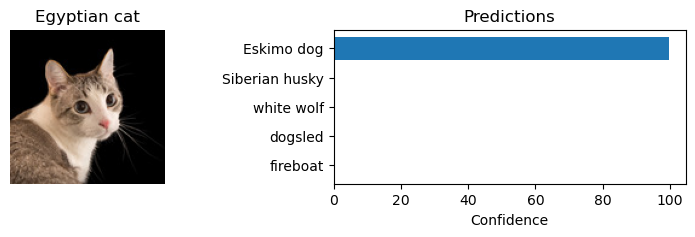

In [8]:
# Step 6: Define the show_prediction function
def show_prediction(img, label, pred, K=5, adv_img=None, noise=None):

    if isinstance(img, torch.Tensor):
        # Tensor image to numpy
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()

    # Plot on the left the image with the true label as title.
    if noise is None or adv_img is None:
        fig, ax = plt.subplots(1, 2, figsize=(10,2), gridspec_kw={'width_ratios': [1, 1]})
    else:
        fig, ax = plt.subplots(1, 5, figsize=(12,2), gridspec_kw={'width_ratios': [1, 1, 1, 1, 2]})

    ax[0].imshow(img)
    ax[0].set_title(label_names[label])
    ax[0].axis('off')

    if adv_img is not None and noise is not None:
        # Visualize adversarial images
        adv_img = adv_img.cpu().permute(1, 2, 0).numpy()
        adv_img = (adv_img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        adv_img = np.clip(adv_img, a_min=0.0, a_max=1.0)
        ax[1].imshow(adv_img)
        ax[1].set_title('Adversarial')
        ax[1].axis('off')
        # Visualize noise
        noise = noise.cpu().permute(1, 2, 0).numpy()
        noise = noise * 0.5 + 0.5 # Scale between 0 to 1
        ax[2].imshow(noise)
        ax[2].set_title('Noise')
        ax[2].axis('off')
        # buffer
        ax[3].axis('off')

    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    ax[-1].barh(np.arange(K), topk_vals*100.0, align='center', color=["C0" if topk_idx[i]!=label else "C2" for i in range(K)])
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence')
    ax[-1].set_title('Predictions')

    plt.show()
    plt.close()

# Step 7: Show original and adversarial predictions
show_prediction(
    img_tensor[0],                # Original image
    original_logits.argmax(),      # True label for the original image
    adv_logits[0],                 # Prediction for the adversarial image
    adv_img=patched_img_tensor[0]  # Adversarial image
)

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchvision import transforms, datasets
import numpy as np
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt

# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Constants for normalization
TENSOR_MEANS = torch.FloatTensor([0.485, 0.456, 0.406])[:, None, None]
TENSOR_STD = torch.FloatTensor([0.229, 0.224, 0.225])[:, None, None]

# Preprocess the input image
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Map patch values to valid range for ImageNet
def patch_forward(patch):
    patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    return patch

# Function to place the patch on the image at random positions
def place_patch(img, patch):
    for i in range(img.shape[0]):
        h_offset = np.random.randint(0, img.shape[2] - patch.shape[1] - 1)
        w_offset = np.random.randint(0, img.shape[3] - patch.shape[2] - 1)
        img[i, :, h_offset:h_offset + patch.shape[1], w_offset:w_offset + patch.shape[2]] = patch_forward(patch)
    return img

# Function to evaluate the patch's effectiveness
def eval_patch(model, patch, val_loader, target_class, device='cpu'):
    model.eval()
    tp, tp_5, counter = 0., 0., 0.
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
            for _ in range(2):  # Reduce random placements to 2
                patch_img = place_patch(img, patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)
                pred = model(patch_img)
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), img_labels != target_class).sum()
                counter += (img_labels != target_class).sum()
    acc = tp / counter
    top5 = tp_5 / counter
    return acc, top5

# Patch attack training loop
def patch_attack(model, dataset, target_class, patch_size=64, num_epochs=1, device='cpu'):
    # Get the length of the dataset
    dataset_length = len(dataset)

    # Split dataset into smaller training and validation sets for speed
    train_size = int(0.9 * dataset_length)  # 90% for training
    val_size = dataset_length - train_size   # 10% for validation
    train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])

    train_loader = data.DataLoader(train_set, batch_size=16, shuffle=True, drop_last=True)  # Reduced batch size
    val_loader = data.DataLoader(val_set, batch_size=16, shuffle=False, drop_last=False)

    # Create the patch parameter
    patch = nn.Parameter(torch.zeros(3, patch_size, patch_size), requires_grad=True)
    optimizer = optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()

    # Training loop with reduced epoch count
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        for img, _ in t:
            img = place_patch(img, patch)
            img = img.to(device)
            pred = model(img)
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            t.set_description(f"Epoch {epoch}, Loss: {loss.item():.4f}")

    # Final validation
    acc, top5 = eval_patch(model, patch, val_loader, target_class, device=device)

    return patch.data, {"acc": acc.item(), "top5": top5.item()}

# Visualize trained patches
def show_patches(patch_dict, class_names, patch_sizes):
    fig, ax = plt.subplots(len(patch_sizes), len(class_names), figsize=(len(class_names)*2.2, len(patch_sizes)*2.2))
    for c_idx, cname in enumerate(class_names):
        for p_idx, psize in enumerate(patch_sizes):
            patch = patch_dict[cname][psize]["patch"]
            patch = (torch.tanh(patch) + 1) / 2  # Map patch to valid pixel range
            patch = patch.cpu().permute(1, 2, 0).numpy()
            patch = np.clip(patch, a_min=0.0, a_max=1.0)
            ax[p_idx][c_idx].imshow(patch)
            ax[p_idx][c_idx].set_title(f"{cname}, size {psize}")
            ax[p_idx][c_idx].axis('off')
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()

# Load a dataset (for example, CIFAR-10 or ImageNet-like dataset)
dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=preprocess)

# Define the model (e.g., ResNet34)
model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
model.eval()

# Define class names and patch sizes
class_names = ['toaster', 'goldfish', 'school bus', 'lipstick', 'pineapple']
patch_sizes = [32, 48, 64]

# Function to train and evaluate patches for multiple classes and sizes
def get_patches(model, class_names, patch_sizes, dataset, device='cpu'):
    result_dict = dict()
    for name in class_names:
        result_dict[name] = dict()
        for patch_size in patch_sizes:
            # Assuming the class names are mapped to CIFAR-10 classes (adjust as necessary)
            c = class_names.index(name)  # Get target class index
            patch, val_results = patch_attack(model, dataset, target_class=c, patch_size=patch_size, num_epochs=1, device=device)
            result_dict[name][patch_size] = {
                "results": val_results,
                "patch": patch
            }
    return result_dict

# Train patches for the specified classes and sizes
patch_dict = get_patches(model, class_names, patch_sizes, dataset)

# Visualize the trained patches
show_patches(patch_dict, class_names, patch_sizes)


Files already downloaded and verified


KeyboardInterrupt: 